In [2]:
import kagglehub
# mathurinache_the_lj_speech_dataset_path = kagglehub.dataset_download('mathurinache/the-lj-speech-dataset')
# andreadiubaldo_wavefake_test_path = kagglehub.dataset_download('andreadiubaldo/wavefake-test')
# asv_spoof_path = kagglehub.dataset_download("awsaf49/asvpoof-2019-dataset/data")
# print('Data source import complete.')


In [3]:
mathurinache_the_lj_speech_dataset_path, andreadiubaldo_wavefake_test_path = ('/home/jovyan/.cache/kagglehub/datasets/mathurinache/the-lj-speech-dataset/versions/1',
 '/home/jovyan/.cache/kagglehub/datasets/andreadiubaldo/wavefake-test/versions/1')

In [4]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical

2025-01-28 02:46:40.272382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 02:46:42.817056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-28 02:46:42.817182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/ext

In [5]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("No TPU found. Using default strategy.")
#     strategy = tf.distribute.get_strategy()
# print(strategy)

In [6]:
import os

paths = []
labels = []

# Define the root directory
real_root_dir = mathurinache_the_lj_speech_dataset_path + "/LJSpeech-1.1/wavs" # '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'
fake_root_dir = andreadiubaldo_wavefake_test_path + "/generated_audio/ljspeech_melgan"  # '/kaggle/input/wavefake-test/generated_audio/ljspeech_melgan'
# Iterate through the subdirectories
for filename in os.listdir(real_root_dir):
    file_path = os.path.join(real_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('real')

for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('fake')

print('Dataset is loaded')


Dataset is loaded


In [7]:
print(len(paths))

26200


In [8]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels


In [9]:
len(labels)

26200

In [10]:
df['label'].value_counts()

real    13100
fake    13100
Name: label, dtype: int64

**Visualization of Audio and Features**

In [11]:
real_audio = '/home/jovyan/.cache/kagglehub/datasets/mathurinache/the-lj-speech-dataset/versions/1/LJSpeech-1.1/wavs/LJ001-0001.wav'
fake_audio = '/home/jovyan/.cache/kagglehub/datasets/andreadiubaldo/wavefake-test/versions/1/generated_audio/ljspeech_melgan/LJ001-0001_gen.wav'

In [12]:
print('Real Audio:')
IPython.display.Audio(real_audio, rate=44100)

Real Audio:


In [13]:
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


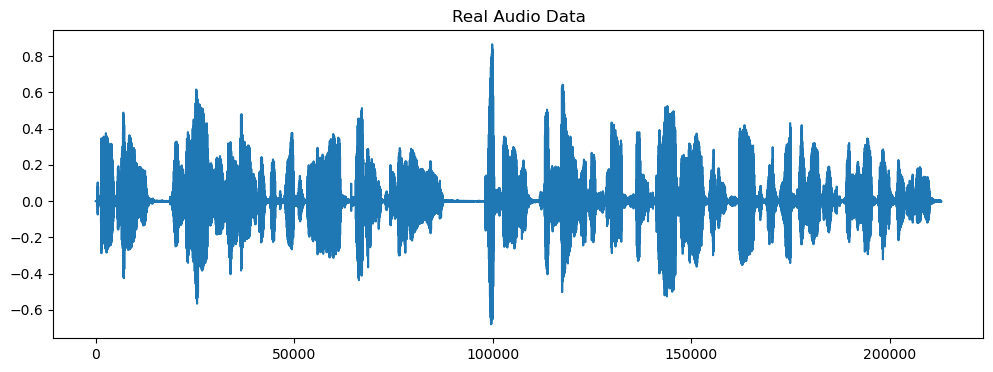

In [14]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data')
plt.show()

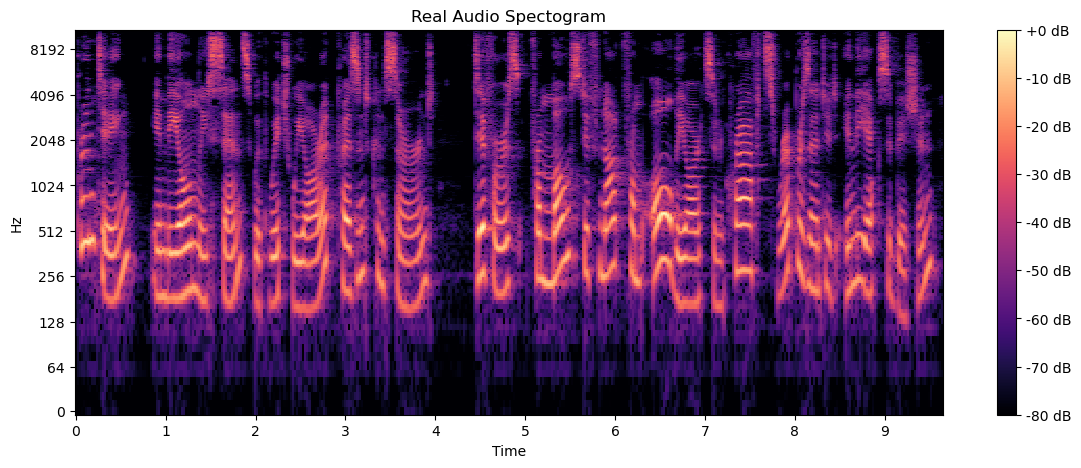

In [15]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram")
plt.show()

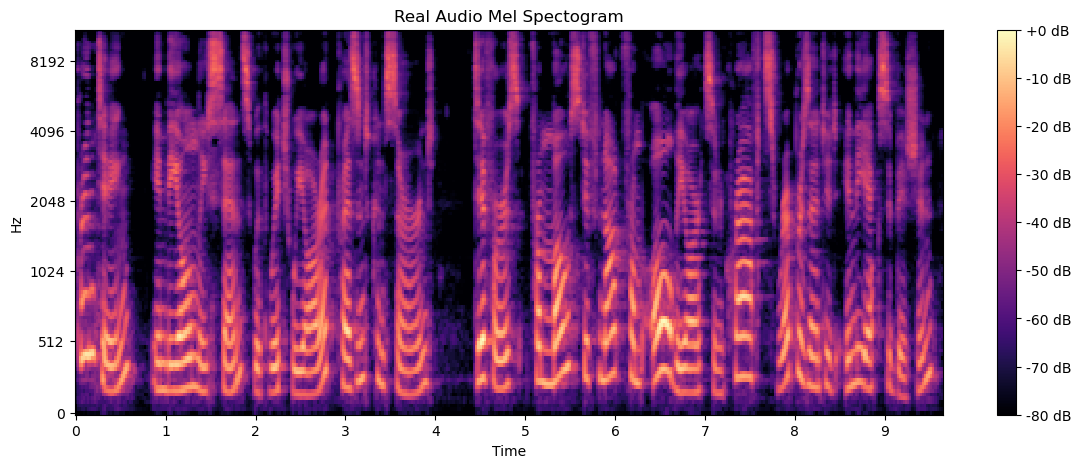

In [16]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

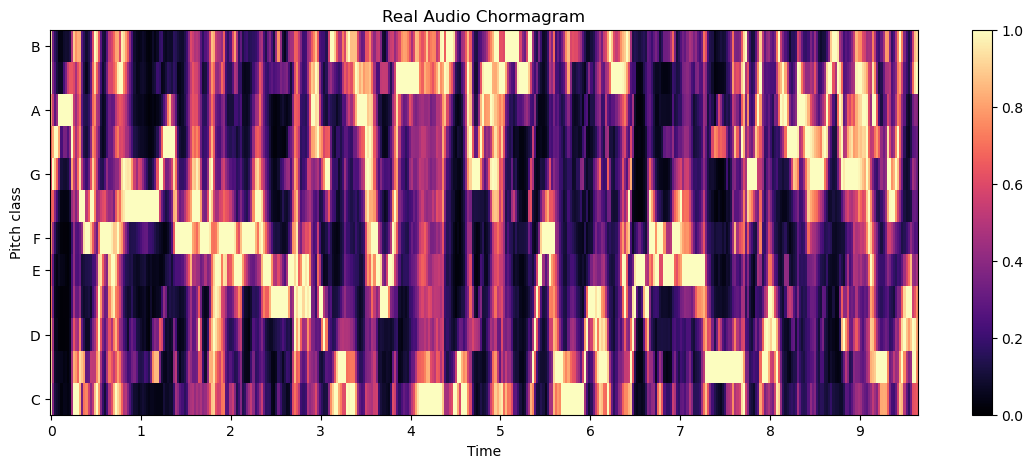

In [17]:
real_chroma = librosa.feature.chroma_cqt(y = real_ad, sr = real_sr, bins_per_octave=36)
plt.figure(figsize = (14, 5))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

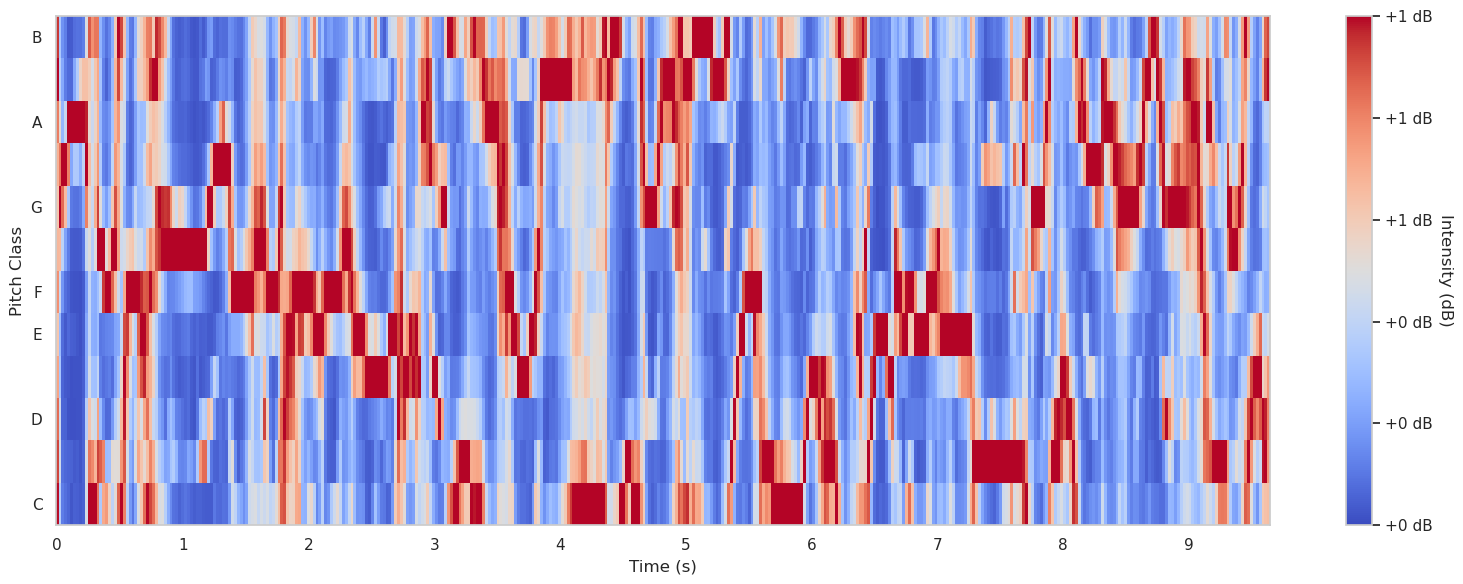

In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

# Load your audio data
# Make sure 'real_ad' and 'real_sr' are defined with your data
# real_ad, real_sr = librosa.load('path_to_your_audio_file.wav')

# Compute chromagram using constant-Q transform
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

# Use Seaborn to set the color palette and style context
sns.set_theme(style='whitegrid')  # Set overall theme
sns.set_palette('muted')          # Seaborn color palette

# Create the plot
plt.figure(figsize=(16, 6))  # Make the figure a bit wider

# Display the chromagram
librosa.display.specshow(real_chroma, sr=real_sr, x_axis='time', y_axis='chroma', cmap='coolwarm', vmin=0, vmax=1)

# Add a colorbar with label
cbar = plt.colorbar(format='%+2.0f dB')
cbar.set_label('Intensity (dB)', rotation=270, labelpad=15)

# Add annotation for context
# plt.title('Beautiful Chromagram of Real Audio', fontsize=18)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Pitch Class', fontsize=12)

# Clean up the layout
plt.tight_layout()

# Display the plot
plt.show()

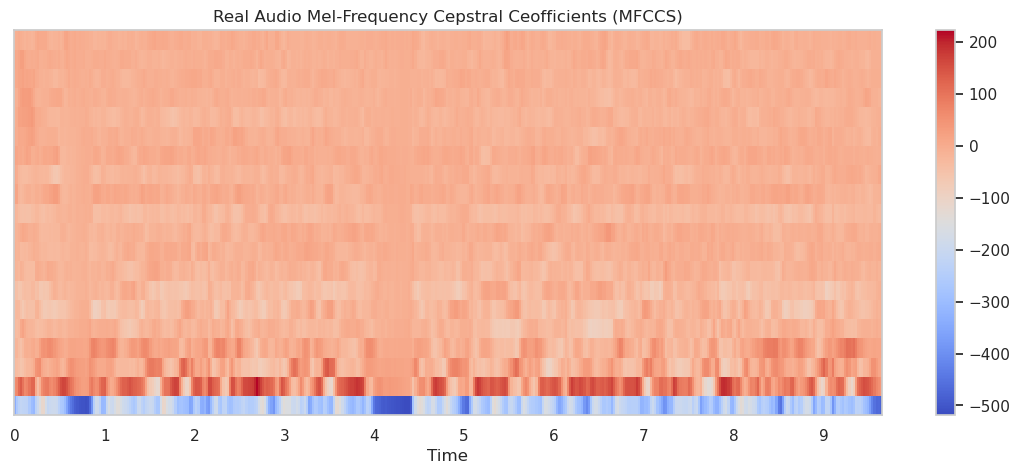

In [19]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mfcc, sr = real_sr, x_axis ='time')
plt.colorbar()
plt.title('Real Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

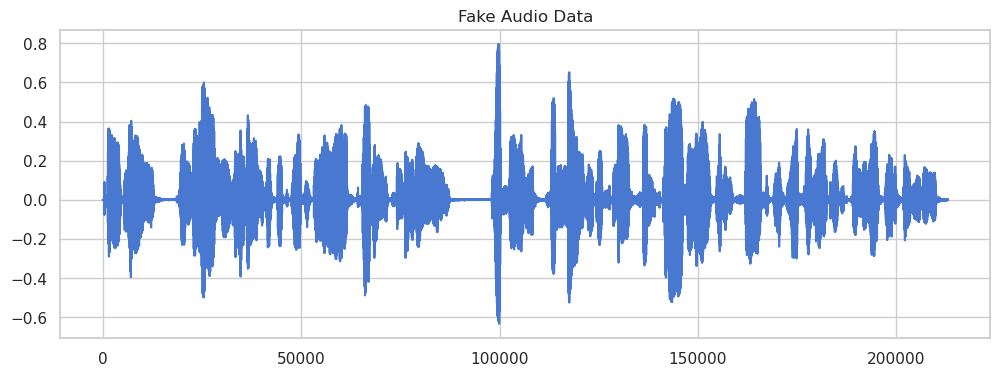

In [20]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize =(12,4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

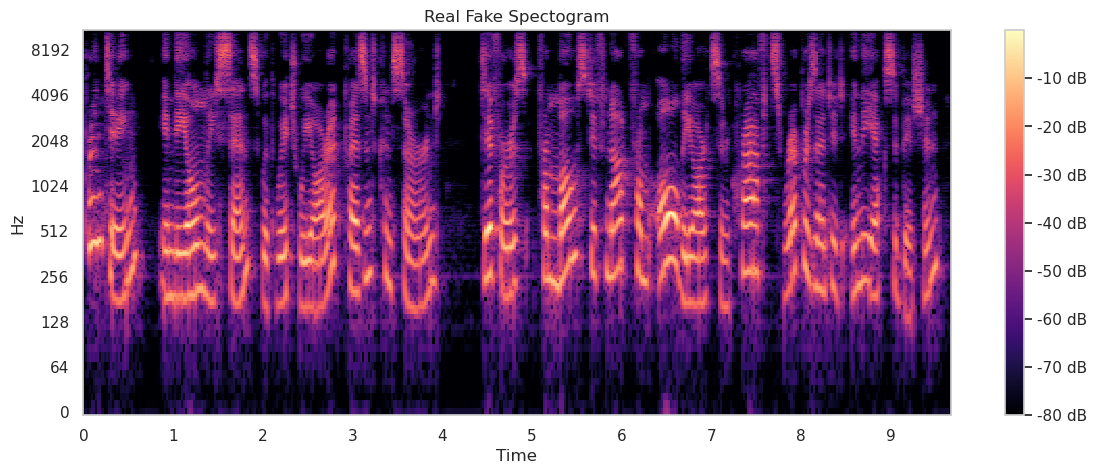

In [21]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Fake Spectogram")
plt.show()

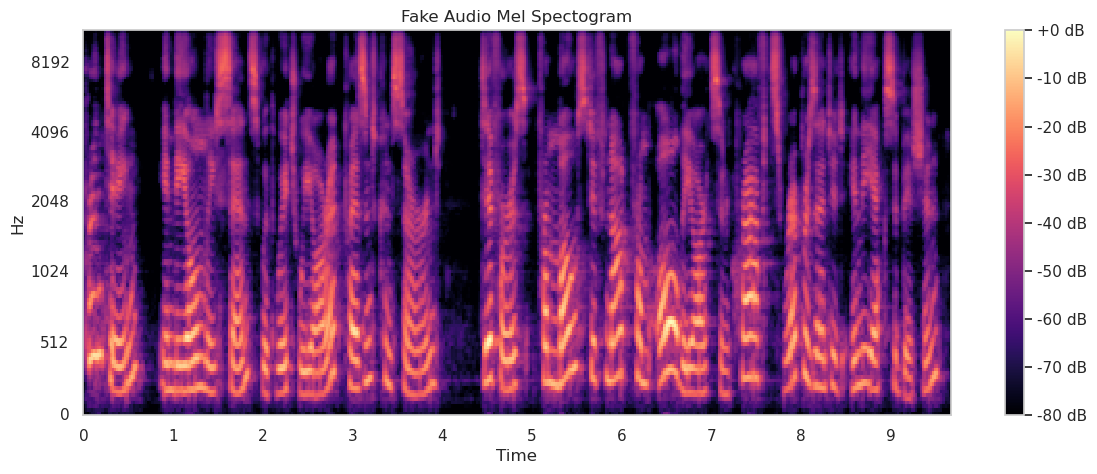

In [22]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()


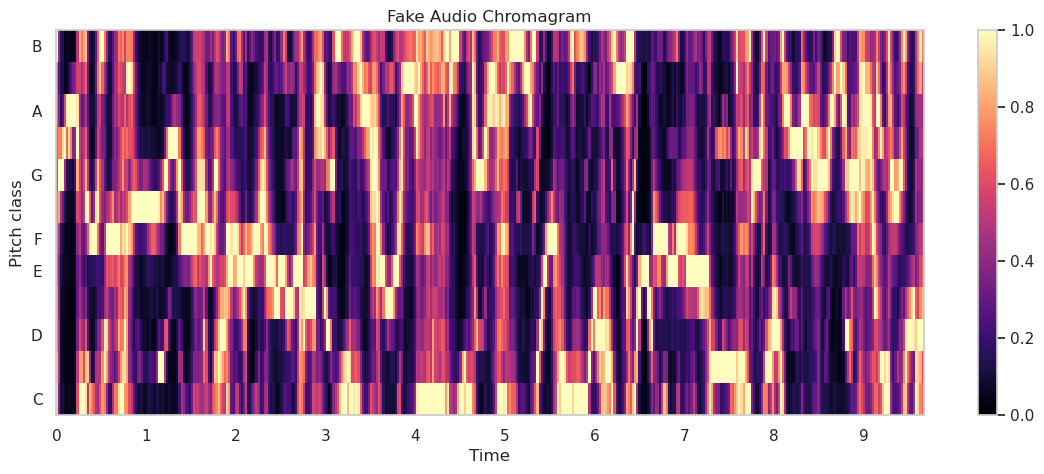

In [23]:
fake_chroma = librosa.feature.chroma_cqt(y = fake_ad, sr = fake_sr, bins_per_octave=36)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_chroma, sr = fake_sr, x_axis= 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Fake Audio Chromagram')
plt.show()

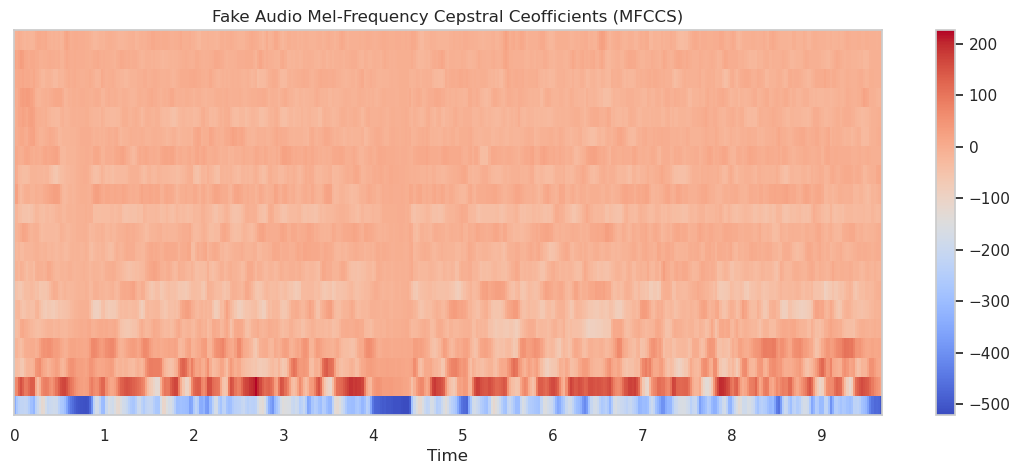

In [24]:
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mfcc, sr = fake_sr, x_axis ='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

In [83]:
EXTRACT = True

def extract_features(fake_root_dir, real_root_dir, max_length=500):
    all_features = []
    features = []
    labels = []

    
    print("Fakes")
    for file in os.listdir(fake_root_dir)[:5]:
        features = []
        file_path = os.path.join(fake_root_dir, file)
        # print("Fake file path:", file_path)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            print("mfccs", mfccs.shape)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=40)

            # Convert power spectrogram (amplitude squared) to decibel (dB) units
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Pad or trim Mel-spectrogram to a fixed length
            if mel_spectrogram_db.shape[1] < max_length:
                mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max_length - mel_spectrogram_db.shape[1])), mode='constant')
            else:
                mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

            # Append Mel-Spectrogram to the features list
            features.append(mel_spectrogram_db)
            print("mel", mel_spectrogram_db.shape)

            # Extract Constant-Q Transform (CQT) features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=40)

            # Get the magnitude of the CQT
            cqt_magnitude = np.abs(cqt)

            # Pad or trim CQT to a fixed length
            if cqt_magnitude.shape[1] < max_length:
                cqt_magnitude = np.pad(cqt_magnitude, ((0, 0), (0, max_length - cqt_magnitude.shape[1])), mode='constant')
            else:
                cqt_magnitude = cqt_magnitude[:, :max_length]

            # Append CQT to the features list
            features.append(cqt_magnitude)
            print("cqt_mag", cqt_magnitude.shape)

            # Extract CQCC features (a more complex operation usually requiring additional tools)
            # Here, we simulate a similar process to MFCC for the sake of simplicity
            # Note: There is no direct CQCC function in librosa; usually done with third-party libraries

            # For demonstration, you can consider using CQT followed by a similar processing to MFCCs
            cqt_db = librosa.amplitude_to_db(cqt)

            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=40)

            # Pad or trim CQCC to a fixed length
            if cqcc.shape[1] < max_length:
                cqcc = np.pad(cqcc, ((0, 0), (0, max_length - cqcc.shape[1])), mode='constant')
            else:
                cqcc = cqcc[:, :max_length]

            # Append CQCC-like features to the features list
            features.append(cqcc)
            print("cqcc", cqcc.shape)

            # Assign label
            labels.append(1)  # 1 for fake
            
            all_features.append(features)
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
            
    print("Reals")

    for file in os.listdir(real_root_dir):
        features = []
        file_path = os.path.join(real_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            
            # Append MFCCs to the features list
            features.append(mfccs)

            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=40)

            # Convert power spectrogram (amplitude squared) to decibel (dB) units
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Pad or trim Mel-spectrogram to a fixed length
            if mel_spectrogram_db.shape[1] < max_length:
                mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max_length - mel_spectrogram_db.shape[1])), mode='constant')
            else:
                mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

            # Append Mel-Spectrogram to the features list
            features.append(mel_spectrogram_db)

            # Extract Constant-Q Transform (CQT) features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=40)

            # Get the magnitude of the CQT
            cqt_magnitude = np.abs(cqt)

            # Pad or trim CQT to a fixed length
            if cqt_magnitude.shape[1] < max_length:
                cqt_magnitude = np.pad(cqt_magnitude, ((0, 0), (0, max_length - cqt_magnitude.shape[1])), mode='constant')
            else:
                cqt_magnitude = cqt_magnitude[:, :max_length]

            # Append CQT to the features list
            features.append(cqt_magnitude)

            # Extract CQCC features (a more complex operation usually requiring additional tools)
            # Here, we simulate a similar process to MFCC for the sake of simplicity
            # Note: There is no direct CQCC function in librosa; usually done with third-party libraries

            # For demonstration, you can consider using CQT followed by a similar processing to MFCCs
            cqt_db = librosa.amplitude_to_db(cqt)

            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=40)

            # Pad or trim CQCC to a fixed length
            if cqcc.shape[1] < max_length:
                cqcc = np.pad(cqcc, ((0, 0), (0, max_length - cqcc.shape[1])), mode='constant')
            else:
                cqcc = cqcc[:, :max_length]

            # Append CQCC-like features to the features list
            features.append(cqcc)

            # Assign label
            labels.append(0)  # 0 for real
            all_features.append(features)
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    return np.array(all_features), np.array(labels)

# Example usage

if EXTRACT:
    x, y = extract_features(fake_root_dir, real_root_dir)
    print("Features shape:", x.shape)
    print("Labels shape:", y.shape)

Fakes
mfccs (40, 500)
mel (40, 500)
cqt_mag (40, 500)
cqcc (40, 500)
mfccs (40, 500)
mel (40, 500)
cqt_mag (40, 500)
cqcc (40, 500)
mfccs (40, 500)
mel (40, 500)
cqt_mag (40, 500)
cqcc (40, 500)
mfccs (40, 500)
mel (40, 500)
cqt_mag (40, 500)
cqcc (40, 500)
mfccs (40, 500)
mel (40, 500)
cqt_mag (40, 500)
cqcc (40, 500)
Reals


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.


Features shape: (10, 4, 40, 500)
Labels shape: (10,)


In [84]:
import os
import numpy as np
import librosa

EXTRACT = True

def extract_features(fake_root_dir, real_root_dir, max_length=500):
    all_features = []
    labels = []
    
    print("Fakes")
    for file in os.listdir(fake_root_dir)[:100]:
        file_path = os.path.join(fake_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            mfccs = pad_or_trim(mfccs, max_length)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=40)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = pad_or_trim(mel_spectrogram_db, max_length)

            # Extract CQT features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=40)
            cqt_magnitude = pad_or_trim(np.abs(cqt), max_length)

            # Extract CQCC features (Simulated from CQT)
            cqt_db = librosa.amplitude_to_db(cqt)
            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=40)
            cqcc = pad_or_trim(cqcc, max_length)
            
            # Stack features
            combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude, cqcc])
            # combined_features = mfccs
            # combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude])
            
            # Append features and labels
            all_features.append(combined_features)
            labels.append(1)  # 1 for fake
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    
    print("Reals")
    for file in os.listdir(real_root_dir)[:100]:
        file_path = os.path.join(real_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            mfccs = pad_or_trim(mfccs, max_length)
            
            # Extract Mel-Spectrogram features
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=40)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = pad_or_trim(mel_spectrogram_db, max_length)

            # Extract CQT features
            cqt = librosa.cqt(y=audio, sr=16000, n_bins=40)
            cqt_magnitude = pad_or_trim(np.abs(cqt), max_length)

            # Extract CQCC features (Simulated from CQT)
            cqt_db = librosa.amplitude_to_db(cqt)
            cqcc = librosa.feature.mfcc(S=cqt_db, n_mfcc=40)
            cqcc = pad_or_trim(cqcc, max_length)
            
            # Stack features
            combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude, cqcc])
            # combined_features = mfccs
            # combined_features = np.vstack([mfccs, mel_spectrogram_db, cqt_magnitude])
            
            # Append features and labels
            all_features.append(combined_features)
            labels.append(0)  # 0 for real
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue

    # Convert lists to NumPy arrays
    return np.array(all_features), np.array(labels)

def pad_or_trim(features, max_length):
    """
    Pads or trims the input feature array to a specific max_length.
    """
    if features.shape[1] < max_length:
        return np.pad(features, ((0, 0), (0, max_length - features.shape[1])), mode='constant')
    else:
        return features[:, :max_length]


if EXTRACT:
    x, y = extract_features(fake_root_dir, real_root_dir)
    print("Features shape:", x.shape)  # Should be (10, 40*4, 500)
    print("Labels shape:", y.shape)    # Should be (10,)

Fakes


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.


Reals


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.


Features shape: (200, 160, 500)
Labels shape: (200,)


In [82]:
# np.save("x2.npy", x)
# np.save("y2.npy", y)

x = np.load('x.npy')
y = np.load('y.npy')

In [85]:
x.shape, y.shape

((200, 160, 500), (200,))

In [86]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

**Model Architecture**

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
# strategy = tf.distribute.get_strategy()

with strategy.scope():
    # Create and compile the model inside the strategy scope
    model = Sequential([
        layers.Reshape((160, 500, 1), input_shape=xtrain.shape[1:]),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print the model summary to confirm the structure
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_22 (Reshape)        (None, 160, 500, 1)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 160, 500, 32)      320       
                                                                 
 batch_normalization_55 (Bat  (None, 160, 500, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 80, 250, 32)      0         
 g2D)                                                            
      

## Training

In [88]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform it
x_train_scaled = scaler.fit_transform(xtrain.reshape(-1, xtrain.shape[-1]))

# Transform the test data using the same scaler
x_test_scaled = scaler.transform(xtest.reshape(-1, xtest.shape[-1]))

# If your original x has more than 2 dimensions, ensure to reshape back to its original
# x_train_scaled = x_train_scaled.reshape(x_train.shape)
# x_test_scaled = x_test_scaled.reshape(x_test.shape)

xtrain.shape

(160, 160, 500)

In [89]:
from tensorflow.keras.callbacks import EarlyStopping

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation accuracy instead of loss
    patience=10,                     # Stop after 10 epochs of no improvement
    restore_best_weights=True,      # Restore the weights from the epoch with the best validation accuracy
    mode='max',                     # 'max' because higher accuracy is better (we want to maximize val_accuracy)
    verbose=1                       # Output when training stops early
)

batch_size = 32 * strategy.num_replicas_in_sync

# Train the model with early stopping
history = model.fit(
    xtrain, ytrain,                 # Training data
    epochs=5,                      # Max number of epochs
    batch_size=32,                  # Batch size
    validation_data=(xtest, ytest),   # Validation data
    # callbacks=[early_stopping]      # Add early stopping callback
)

Epoch 1/5
5/5 [==============================] - 1s 254ms/step - loss: 1.0482 - accuracy: 0.4625 - val_loss: 0.8935 - val_accuracy: 0.4000
Epoch 2/5
5/5 [==============================] - 1s 242ms/step - loss: 1.0525 - accuracy: 0.5250 - val_loss: 0.8868 - val_accuracy: 0.4000
Epoch 3/5
5/5 [==============================] - 1s 246ms/step - loss: 0.9789 - accuracy: 0.5625 - val_loss: 0.8751 - val_accuracy: 0.4000
Epoch 4/5
5/5 [==============================] - 1s 241ms/step - loss: 1.0194 - accuracy: 0.5500 - val_loss: 0.8640 - val_accuracy: 0.4000
Epoch 5/5
5/5 [==============================] - 1s 239ms/step - loss: 0.9843 - accuracy: 0.4750 - val_loss: 0.8604 - val_accuracy: 0.4000


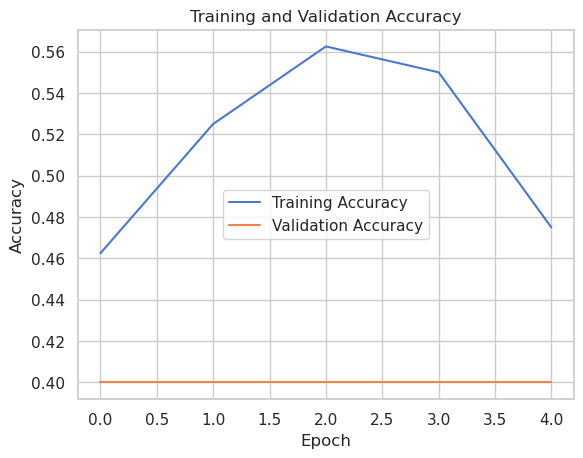

In [90]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [33]:
loss, accuracy = model.evaluate(xtest,ytest)

164/164 [==============================] - 3s 19ms/step - loss: 0.0964 - accuracy: 0.9788


In [34]:
loss, accuracy

(0.09637404978275299, 0.97881680727005)

In [35]:
cpu_model = tf.keras.models.clone_model(model)
cpu_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Copy weights from the TPU model to the CPU model
cpu_model.set_weights(model.get_weights())

# Save only the weights of the CPU model
cpu_model.save_weights('v_test.h5')

In [36]:
# Create a CPU model with the same architecture
cpu_model = tf.keras.models.clone_model(model)
cpu_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Copy weights from TPU model to CPU model
cpu_model.set_weights(model.weights)

# Save the CPU model
cpu_model.save('v2.h5')